### Import

In [1]:
import sys
import numpy as np
import xarray as xr
import netCDF4 as nc
# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
# plot styles/formatting
import cmocean.cm as cmo
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
# other
import wrf


# Path to modules
sys.path.append('../modules')

# Import my modules
from xarrayMannKendall import *
from plotter import draw_basemap

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                                      # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/HASIA_ch2_analysis/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/HASIA_ch2_analysis/figs/'      # figures


In [3]:
def select_months_ds(ds, mon_s, mon_e):    
    # Select months
    if mon_s > mon_e:
        idx = (ds.time.dt.month >= mon_s) | (ds.time.dt.month <= mon_e)
    else:
        idx = (ds.time.dt.month >= mon_s) & (ds.time.dt.month <= mon_e)
    ds = ds.sel(time=idx)
    return ds

def combine_ar_ds_df(ds, df):
    # Combine AR Cat data w/ WRF data
    # Add ar time series to the WRF dataset
    ds['ar'] = ('time', df.AR_CAT)
    ds = ds.set_coords('ar')

    ds['trackID'] = ('time', df.kidmap)
    ds = ds.set_coords('trackID')
    idx = (ds.ar >= 1)
    # select AR days
    ds_ar = ds.sel(time=idx)
    return ds_ar

def compute_MK_trend_da(da):
    # rename coords lat,lon to y,x because that is what the function needs
    da = da.rename({'lat': 'y', 'lon': 'x'})

    # rechunk dask version of data so it is a single chunk
    da_new = da.chunk({'time': -1})
    # # load data since since it can fit into memory
    da_new = da_new.load()
    
    # Compute trends using Mann-Kendall test - takes roughly 2 seconds!
    MK_class = Mann_Kendall_test(da_new, 'time')
    MK_trends = MK_class.compute() 
    return MK_trends

### Run a simple [example](https://github.com/josuemtzmo/xarrayMannKendall/blob/master/test/test_3d_arrays.py) with 3D ds array

In [4]:
# # Time series length
# n=100
# time = np.arange(n)
# # Grid
# x = np.arange(4)
# y = np.arange(4)

# # Create dataarray
# data = np.zeros((len(time), len(x), len(y)))
# da = xr.DataArray(data, coords=[time, x, y], 
#                   dims=['time', 'x', 'y'])
# # Create noise
# noise = np.random.randn(*np.shape(data))

# # Create dataarray with positive linear trend
# linear_trend = xr.DataArray(time, coords=[time], dims=['time'])

# # Add noise to trend
# da_with_linear_trend = (da + linear_trend) + noise
# da_with_linear_trend

In [5]:
# %%time
# # Compute trends using Mann-Kendall test
# MK_class = Mann_Kendall_test(da_with_linear_trend, 'time')
# MK_trends = MK_class.compute() 
# MK_trends

In [6]:
# MK_trends.trend.plot.contourf()


### Now let's run a more complicated example with actual data

In [7]:
start_date = '1979-01-01 00:00'
end_date = '2019-05-31 18:00'
mon_s = 12
mon_e = 2
ssn='DJF'

# Select lat/lon grid
# latmin, latmax, lonmin, lonmax
bbox = [10, 50, 20, 100]
latmin, latmax, lonmin, lonmax = bbox

filename =  'globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'

# open ds
ds = xr.open_dataset(path_to_data + 'ar_catalog/' + filename, chunks={'time': 1460}, engine='netcdf4')
ds = ds.squeeze()
# remove lev and ens coords
ds = ds.reset_coords(names=['lev', 'ens'], drop=True)

# select lats, lons, and dates within start_date, end_date and months
lat1, lat2, lon1, lon2 = bbox
ds = ds.sel(time=slice(start_date, end_date), lat=slice(lat1,lat2), lon=slice(lon1,lon2))
ds

<xarray.Dataset>
Dimensions:      (lat: 27, lon: 53, time: 59044)
Coordinates:
  * lon          (lon) float64 21.0 22.5 24.0 25.5 27.0 ... 94.5 96.0 97.5 99.0
  * lat          (lat) float64 10.5 12.0 13.5 15.0 16.5 ... 45.0 46.5 48.0 49.5
  * time         (time) datetime64[ns] 1979-01-01 ... 2019-05-31T18:00:00
Data variables: (12/52)
    islnd        (lat, lon) float32 dask.array<chunksize=(27, 53), meta=np.ndarray>
    iscst        (lat, lon) float32 dask.array<chunksize=(27, 53), meta=np.ndarray>
    shape        (time, lat, lon) float32 dask.array<chunksize=(1460, 27, 53), meta=np.ndarray>
    axis         (time, lat, lon) float64 dask.array<chunksize=(1460, 27, 53), meta=np.ndarray>
    tnsct        (time, lat, lon) float64 dask.array<chunksize=(1460, 27, 53), meta=np.ndarray>
    lfloc        (time, lat, lon) float32 dask.array<chunksize=(1460, 27, 53), meta=np.ndarray>
    ...           ...
    axisidx      (time, lat, lon) float64 dask.array<chunksize=(1460, 27, 53), meta=np.ndarray>
    axislon      (time, lat, lon) float64 dask.array<chunksize=(1460, 27, 53), meta=np.ndarray>
    axislat      (time, lat, lon) float64 dask.array<chunksize=(1460, 27, 53), meta=np.ndarray>
    xtnsctidx    (time, lat, lon) float64 dask.array<chunksize=(1460, 27, 53), meta=np.ndarray>
    numobj       (time, lat, lon) float32 dask.array<chunksize=(1460, 27, 53), meta=np.ndarray>
    kcnt         (time) float64 dask.array<chunksize=(1460,), meta=np.ndarray>
Attributes:
    title:           Global Atmospheric River Database
    version:         2020.02.13
    creation_date:   13-Feb-2020 16:36:39
    tARget_version:  3
    references:      (1) Guan, B., and D. E. Waliser (2015), Detection of atm...

In [8]:
%%time
# set data to equal 1 where the value is not nan
da = ds.shape.where(~(ds.shape == np.nan), 1)

# resample to monthly frequency
ar_ds_mon = da.resample(time='MS').sum()
ar_ds_mon = ar_ds_mon/4. # divide by number of time steps per day to make units (# AR days per month)

# resample to seasonal frequency
ar_ds_ssn = da.resample(time="QS-DEC").sum()
ar_ds_ssn = ar_ds_ssn/4. # divide by number of time steps per day to make units (# AR days per season)

# ### aggregate by month
# ar_ds_mon = da.groupby("time.month").sum("time")



CPU times: user 3.45 s, sys: 51.7 ms, total: 3.51 s
Wall time: 3.51 s


In [9]:
ar_ds_ssn

<xarray.DataArray 'shape' (time: 162, lat: 27, lon: 53)>
dask.array<truediv, shape=(162, 27, 53), dtype=float32, chunksize=(1, 27, 53), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1978-12-01 1979-03-01 ... 2019-03-01
  * lon      (lon) float64 21.0 22.5 24.0 25.5 27.0 ... 93.0 94.5 96.0 97.5 99.0
  * lat      (lat) float64 10.5 12.0 13.5 15.0 16.5 ... 43.5 45.0 46.5 48.0 49.5

### Compute Trends

In [10]:
%%time
#### compute trend for each month
mon_lst = [12, 1, 2]
final_trend = []
for i, mon in enumerate(mon_lst):
    # select single month
    idx = (ar_ds_mon.time.dt.month == mon)
    da = ar_ds_mon.sel(time=idx)
    trend = compute_MK_trend_da(da)
    final_trend.append(trend)
    
## compute trend for DJF
# select single season
idx = (ar_ds_ssn.time.dt.month == 12)
da = ar_ds_ssn.sel(time=idx)
trend = compute_MK_trend_da(da)

CPU times: user 1min 15s, sys: 9.81 s, total: 1min 25s
Wall time: 1min 16s


In [11]:
# get terrain height from one wrf file
wrf_filename = "/work2/08540/dlnash/frontera/wrf_norris/20211113_case/wrfout_d01_2010-02-04_03:00:00"
wrf_filename = "/home/hasia/2009/wrfout_d01_2010-02-04_03:00:00"
wrfin = nc.Dataset(wrf_filename)
ter = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height

### Plot

In [12]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+10,10)

# hack for tick labels
share_right = [False]*2 + [True]
mon_sel = [12, 1, 2]

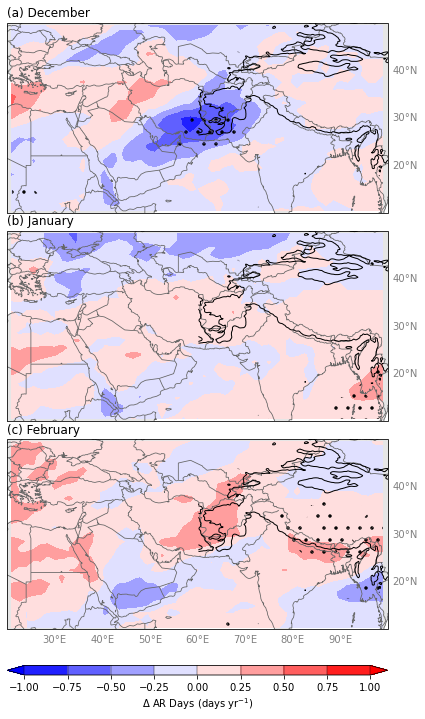

In [16]:
filepath = path_to_figs + 'arfreq_AR_trend_mon' + '.png'
plt_lst = ['(a) December', '(b) January', '(c) February']
share_bottom = [False]*2 + [True]

# Create figure
fig = plt.figure(figsize=(10,12))
nrows = 3
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.25,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.25, cbar_size='5%',label_mode='',
                direction='row')

# Loop for drawing each plot
for k, (ax, mon) in enumerate(zip(axgr, mon_sel)):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=True, bottom_lons=share_bottom[k])
    # Data for plotting
    data = final_trend[k].trend.values
    lons = final_trend[k].x.values
    lats = final_trend[k].y.values
    
    # Contour Filled
    cflevs = np.arange(-1, 1.25, 0.25)
    cf = ax.contourf(lons, lats, data, transform=datacrs,
                    levels=cflevs,cmap='bwr', extend='both')

    # Stippling Significant values
    pval_mask = final_trend[k].p.where((final_trend[k].p <= 0.05)).values
    cs = ax.contourf(lons, lats, pval_mask, colors='none', hatches=['.'])
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    # Subtitles
    ax.set_title(plt_lst[k], loc='left', fontsize=12)
#     ax.annotate(plt_lst[k], (5, 237), xycoords='axes points', fontsize=12.,
#                 backgroundcolor='white')

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(u'$\Delta$ AR Days (days yr$^{-1}$)', fontsize=10)
cb.ax.tick_params(labelsize=10)
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()

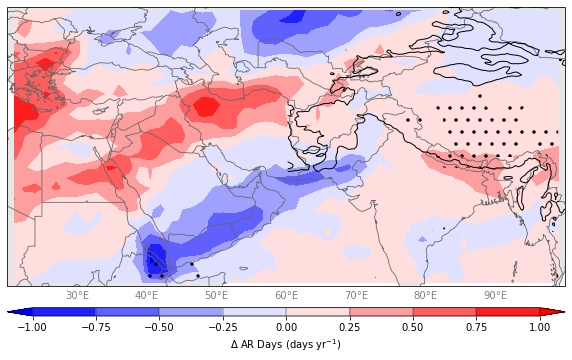

In [20]:
filepath = path_to_figs + 'arfreq_AR_trend_ssn' + '.png'
plt_lst = ['(a) December', '(b) January', '(c) February']

# Create figure
fig = plt.figure(figsize=(10,12))
nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.25, cbar_size='3%',label_mode='',
                direction='row')

# Loop for drawing each plot
for k, (ax, mon) in enumerate(zip(axgr, mon_sel)):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k])
    # Data for plotting
    data = trend.trend.values
    lons = trend.x.values
    lats = trend.y.values
    
    # Contour Filled
    cflevs = np.arange(-1, 1.25, 0.25)
    cf = ax.contourf(lons, lats, data, transform=datacrs,
                    levels=cflevs,cmap='bwr', extend='both')

    # Stippling Significant values
    pval_mask = trend.p.where((trend.p <= 0.05)).values
    cs = ax.contourf(lons, lats, pval_mask, colors='none', hatches=['.'])
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    # Subtitles
    # ax.set_title(plt_lst[k], loc='left', fontsize=12)
#     ax.annotate(plt_lst[k], (5, 237), xycoords='axes points', fontsize=12.,
#                 backgroundcolor='white')

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(u'$\Delta$ AR Days (days yr$^{-1}$)', fontsize=10)
cb.ax.tick_params(labelsize=10)
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()